# Проект: Прогнозирование заказов такси

## Описание проекта
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.
## План проекта

1. [Импорт данных и предобработка](#prep)
2. [Анализ данных](#analysis)
3. [Построение моделей](#model)
4. [Выводы](#concl)

Загрузите данные и выполните их ресемплирование по одному часу.
Проанализируйте данные.
Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
Проверьте данные на тестовой выборке и сделайте выводы.
## Описание данных


Количество заказов находится в столбце `num_orders`

## Используемые библиотеки
В следующей ячейке будем хранить все импортированные библиотеки

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler, StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import TimeSeriesSplit

from lightgbm import LGBMRegressor
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

### Импорт данных и предобработка <a id='prep'></a>

In [2]:
try:
    df =  pd.read_csv('C:/Users/79153/Desktop/ya_projects/sprint_15/taxi.csv')
except:
    df = pd.read_csv('/datasets/taxi.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
df.head(5)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
df['datetime'] = pd.to_datetime(df['datetime'],format='%Y-%m-%d %H:%M:%S')  # изменение формата данных
df = df.set_index('datetime')                                               # установка индекса
print(df.index.is_monotonic)                                                # проверка на монотонность
df.sort_index(inplace=True)                                                 # сортировка по индексу

True


#### Вывод
Данные представляют из себя временной ряд с количеством заказов. По сути данные готовы к работе.

### Анализ данных <a id='analysis'></a>

Выполним ресемплирование по одному часу

In [7]:
df = df.resample('1H').sum()

In [8]:
df['rolling_mean'] = df['num_orders'].rolling(24).mean()
df['rolling_std'] = df['num_orders'].rolling(24).mean()

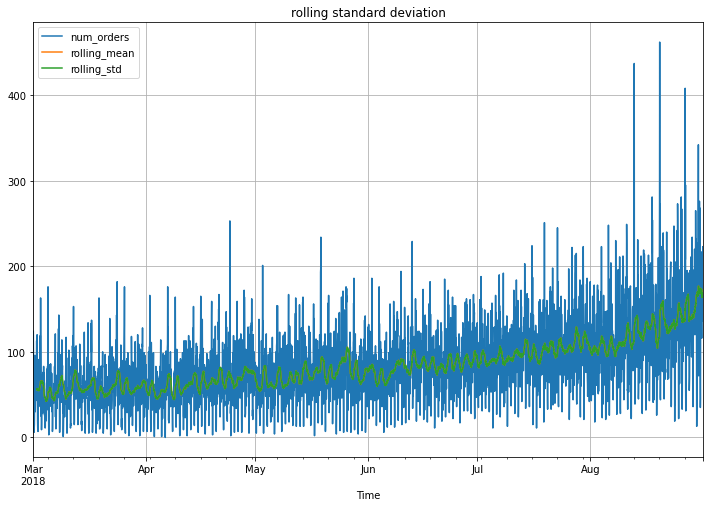

In [9]:
ax = df.plot(figsize=[12,8])
ax.grid()
ax.set_title("rolling standard deviation")
ax.set_xlabel("Time")
plt.show()

Докажем стационарность выборки с помощью теста Дики-Фуллера

In [10]:
ts = df['num_orders']
st_test = adfuller(ts, regression='ctt')

# зададим p_value
p_value=0.05

print('Заданное занчение p_value: ', p_value)
print(f'Значение с индексом "1": {st_test[1]}')
if st_test[1] < p_value:
    print('Ряд стационарный')
else:
    print('Ряд нестационарный')

Заданное занчение p_value:  0.05
Значение с индексом "1": 4.054939777566544e-17
Ряд стационарный


Создадим признаки - ввиду ограниченности интервала времени можно объективно рассматривать час суток и день недели, номер месяца и дня внесут лишний шум в данные

In [11]:
def make_features(data, max_lag):
    copy_data = data.copy()
    copy_data['dayofweek'] = copy_data.index.dayofweek
    copy_data['hour'] = copy_data.index.hour
    copy_data['rolling_mean_shift'] = copy_data['num_orders'].rolling(24).mean().shift()
    for lag in range(1, max_lag + 1):
        copy_data['lag_{}'.format(lag)] = copy_data['num_orders'].shift(lag)
    return copy_data

In [12]:
data = make_features(df, 5)

Проведем декомпозицию

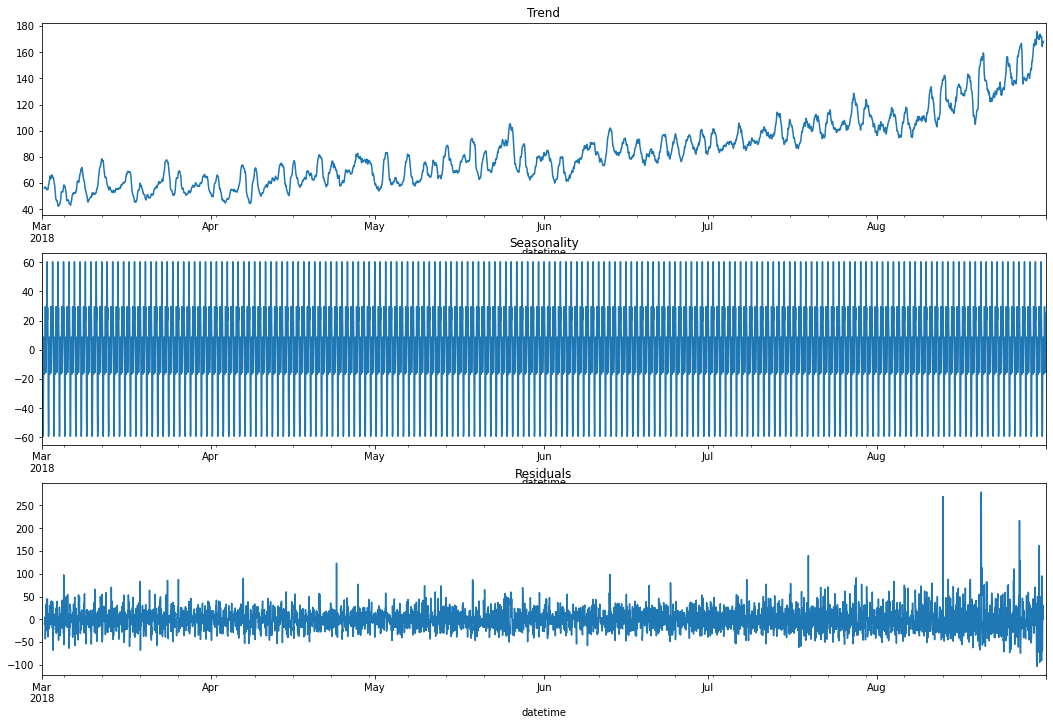

In [13]:
decomposed = seasonal_decompose(data['num_orders'])
fig,ax = plt.subplots(3,1,figsize = (18,12))

decomposed.trend.plot(ax=ax[0],title = 'Trend')
decomposed.seasonal.plot(ax=ax[1],title = 'Seasonality')
decomposed.resid.plot(ax=ax[2],title = 'Residuals')
plt.show()

Рассмотрим сезонность на примере июня, полной недели июня (11-17) и одного дня (11 июня)

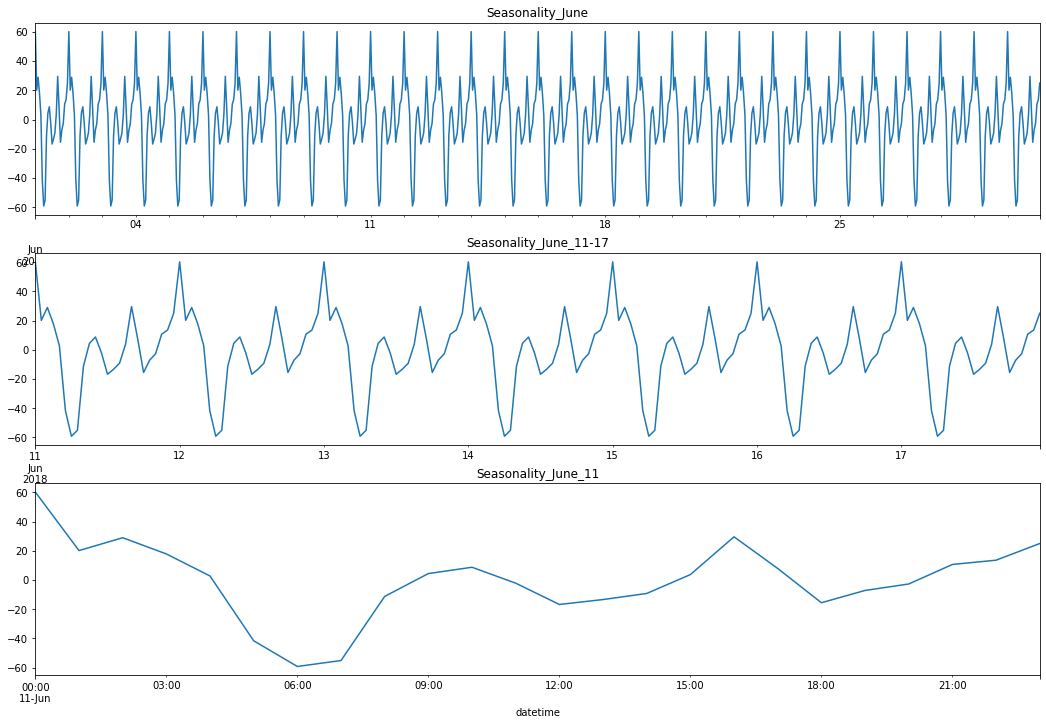

In [14]:
fig,ax = plt.subplots(3,1,figsize = (18,12))
decomposed.seasonal['2018-06-01':'2018-06-30'].plot(ax=ax[0],title = 'Seasonality_June')
decomposed.seasonal['2018-06-11':'2018-06-17'].plot(ax=ax[1],title = 'Seasonality_June_11-17')
decomposed.seasonal['2018-06-11':'2018-06-11'].plot(ax=ax[2],title = 'Seasonality_June_11')
plt.show()

#### Вывод
В наличии тренд на рост числа заказов, выраженная сезонность, достаточно монотонный остаток с небольшим всплеском к концу периода.

### Построение моделей <a id='model'></a>

Удалим нулевые значения из датафрейма

In [15]:
data.dropna(inplace=True)

In [16]:
data = data.drop(["rolling_std", 'rolling_mean'], axis=1)

Проведем разбиение на выборки

In [17]:
train,test = train_test_split(data, shuffle = False, random_state = 123, test_size = 0.1)

train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']

test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

Пайплайн

In [18]:
def initial_model(model, parameters, regressor):

    # пайплайн
    pipe = Pipeline([('normalizer', StandardScaler()), (regressor, model)])
    
    cv = TimeSeriesSplit(n_splits=5)
    grid_search_cv = GridSearchCV(estimator=pipe, param_grid=parameters, cv=cv)
    return grid_search_cv
def result_model(model):
    # обучение и предсказание
    model.fit(train_features,train_target)
    predicted = model.predict(test_features)
    # расчет метрики
    score = mean_squared_error(test_target, predicted, squared=False).round(3)
    
    # добавим визуализацию
    fig,ax = plt.subplots(1,1,figsize = (18,12))
    
    ax.plot(test_target.index,test_target,  c = 'ForestGreen', alpha=0.75)
    ax.plot(test_target.index,predicted, c = 'skyblue', linewidth=2)
    ax.set_facecolor('#F0FFFF')
    ax.set_title('Scattering of predictions')
    ax.legend(['True_test', 'Predictions'], fontsize=20)
    ax.grid(axis='both')
    return score

Обучение

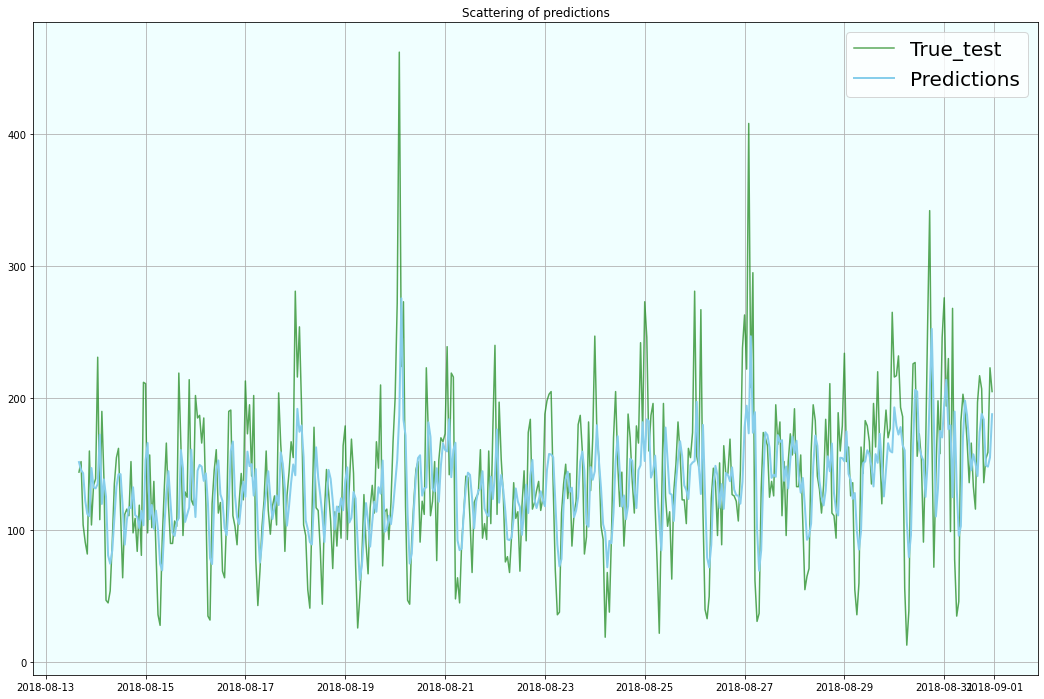

In [19]:
RD = initial_model(model=Ridge(),
                   parameters= {'ridge__alpha': range(0,50),
                                'ridge__fit_intercept': [True, False],
                                'ridge__copy_X': [True, False]},
                   regressor='ridge')
RD_result = result_model(RD)

In [20]:
print('Ridge RMSE:', RD_result)

Ridge RMSE: 50.338


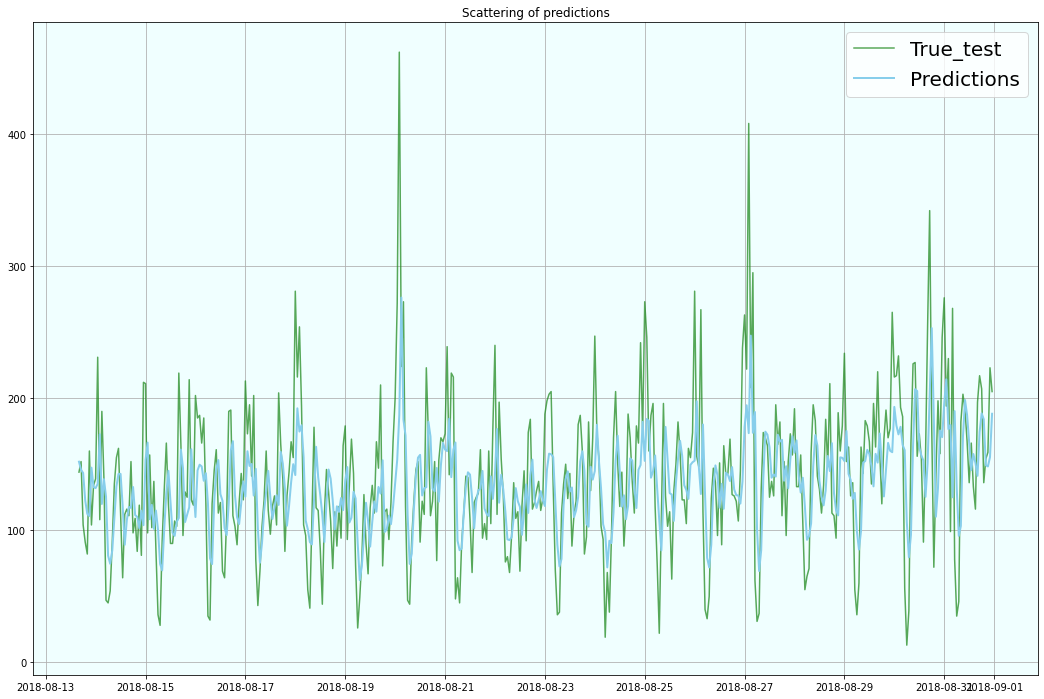

In [21]:
LO = initial_model(model=Lasso(),
                   parameters= {'lasso__alpha': range(0,50),
                                'lasso__fit_intercept': [True, False],
                                'lasso__copy_X': [True, False]},
                   regressor='lasso')
LO_result = result_model(LO)

In [22]:
print('Lasso RMSE:',LO_result)

Lasso RMSE: 50.315


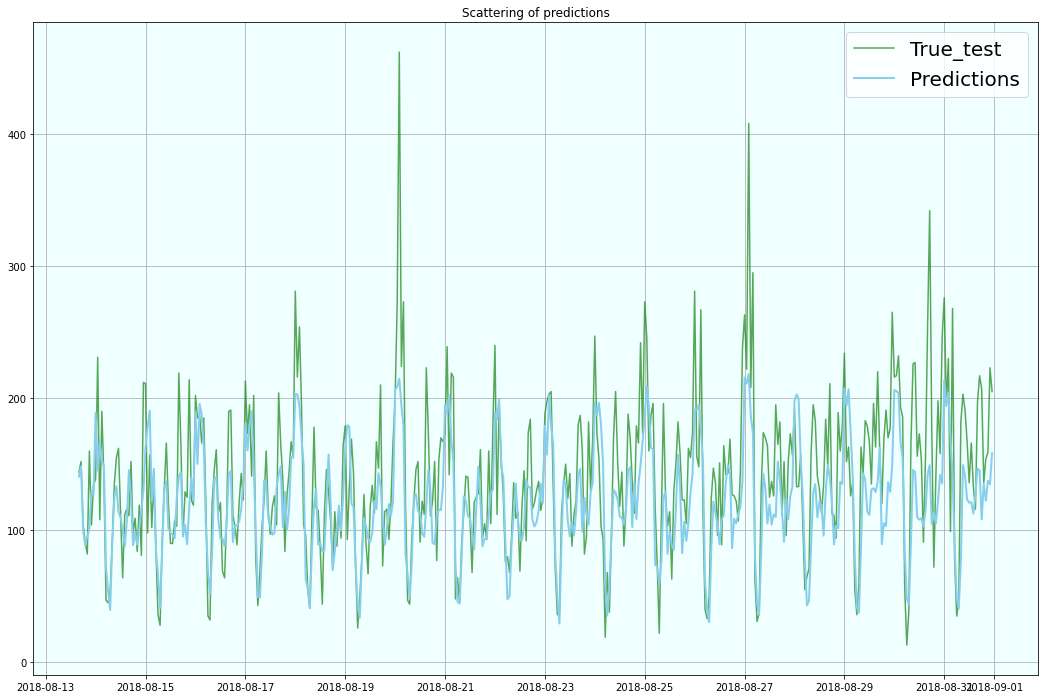

In [23]:
LGBMR = initial_model(model=LGBMRegressor(),
                   parameters= {'LGBMR__max_depth': range(0, 15),
                                'LGBMR__n_estimators': range(20, 100, 10),
                                'LGBMR__num_leaves': range(10, 40, 5)},
                   regressor='LGBMR')
LGBMR_result = result_model(LGBMR)

In [24]:
print('LGBMR RMSE:',LGBMR_result)

LGBMR RMSE: 43.487


### Вывод <a id='concl'></a>

Для данной выборки наилучший результат показала модель на основе LGBM. Следует учитывать что модель отражает в первую очередь зависимость от дня недели и времени суток, годовые и месячные зависимости в нее не входят так как для построения использовался датасет на полгода.